<a href="https://colab.research.google.com/github/goco41/ind-4-alphas/blob/main/ind2alphas_(pc_no_tira).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Old**

In [ ]:
%%writefile utils4alphas_old.py
import pandas as pd
import numpy as np
import os
from numba import njit
from scipy.stats import norm, skew, kurtosis
from itertools import combinations

# Gestión de datos
@njit
def compute_heikin_ashi_numba(op, hi, lo, cl):
    n = len(cl)
    ha_open = np.zeros(n)
    ha_high = np.zeros(n)
    ha_low = np.zeros(n)
    ha_close = np.zeros(n)

    ha_open[0] = op[0]
    ha_close[0] = (op[0] + hi[0] + lo[0] + cl[0]) / 4
    ha_high[0] = hi[0]
    ha_low[0] = lo[0]

    for i in range(1, n):
        ha_close[i] = (op[i] + hi[i] + lo[i] + cl[i]) / 4
        ha_open[i] = (ha_open[i-1] + ha_close[i-1]) / 2
        ha_high[i] = max(hi[i], ha_open[i], ha_close[i])
        ha_low[i] = min(lo[i], ha_open[i], ha_close[i])

    return ha_open, ha_high, ha_low, ha_close

def load_and_prepare_multi_data(folder_path, pairs_list, target_pair_for_execution):
    print(f"Iniciando carga masiva y cálculo HA: {len(pairs_list)} pares")
    master_df = None
    files = os.listdir(folder_path)

    for pair in pairs_list:
        ask_file = next((f for f in files if pair in f and 'ASK' in f), None)
        bid_file = next((f for f in files if pair in f and 'BID' in f), None)

        if not ask_file or not bid_file:
            continue

        df_ask = pd.read_csv(os.path.join(folder_path, ask_file))
        df_bid = pd.read_csv(os.path.join(folder_path, bid_file))

        df_ask.columns = [c.strip() for c in df_ask.columns]
        df_bid.columns = [c.strip() for c in df_bid.columns]

        date_fmt = '%d.%m.%Y %H:%M:%S.%f GMT%z'
        try:
            df_ask['Local time'] = pd.to_datetime(df_ask['Local time'], format=date_fmt, utc=True)
            df_bid['Local time'] = pd.to_datetime(df_bid['Local time'], format=date_fmt, utc=True)
        except:
            df_ask['Local time'] = pd.to_datetime(df_ask['Local time'])
            df_bid['Local time'] = pd.to_datetime(df_bid['Local time'])

        df_ask.set_index('Local time', inplace=True)
        df_bid.set_index('Local time', inplace=True)

        df_pair = pd.merge(df_ask, df_bid, left_index=True, right_index=True, suffixes=('_ask', '_bid'))

        for col in ['Open', 'High', 'Low', 'Close']:
            df_pair[f'{col}_mid'] = (df_pair[f'{col}_ask'] + df_pair[f'{col}_bid']) / 2

        ha_o, ha_h, ha_l, ha_c = compute_heikin_ashi_numba(
            df_pair['Open_mid'].values, df_pair['High_mid'].values,
            df_pair['Low_mid'].values, df_pair['Close_mid'].values
        )

        df_pair[f'HA_Open_{pair}'] = ha_o
        df_pair[f'HA_High_{pair}'] = ha_h
        df_pair[f'HA_Low_{pair}'] = ha_l
        df_pair[f'HA_Close_{pair}'] = ha_c

        df_pair.rename(columns={
            'Open_mid': f'Open_mid_{pair}', 'High_mid': f'High_mid_{pair}',
            'Low_mid': f'Low_mid_{pair}', 'Close_mid': f'Close_mid_{pair}',
            'Open_ask': f'Open_ask_{pair}', 'Open_bid': f'Open_bid_{pair}',
            'Close_ask': f'Close_ask_{pair}', 'Close_bid': f'Close_bid_{pair}'
        }, inplace=True)

        cols_to_keep = [c for c in df_pair.columns if pair in c]
        if master_df is None: master_df = df_pair[cols_to_keep]
        else: master_df = pd.merge(master_df, df_pair[cols_to_keep], left_index=True, right_index=True)

    if master_df is not None:
        print(f"Carga completa. Shape: {master_df.shape}")
        master_df.dropna(inplace=True)
    return master_df

# Indicadores técnicos
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.ewm(com=period - 1, min_periods=period).mean()
    avg_loss = loss.ewm(com=period - 1, min_periods=period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def calculate_macd_lines(series, fast=12, slow=26, signal=9):
    fast_ema = series.ewm(span=fast, adjust=False).mean()
    slow_ema = series.ewm(span=slow, adjust=False).mean()
    macd_line = fast_ema - slow_ema
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    return macd_line, signal_line

def calculate_stoch(high, low, close, k_window=14, d_window=3):
    low_min = low.rolling(window=k_window).min()
    high_max = high.rolling(window=k_window).max()
    k = 100 * ((close - low_min) / (high_max - low_min))
    d = k.rolling(window=d_window).mean()
    return k, d

def calculate_williams_r(high, low, close, period=14):
    low_min = low.rolling(window=period).min()
    high_max = high.rolling(window=period).max()
    return -100 * ((high_max - close) / (high_max - low_min))

def calculate_ppo(series, fast=12, slow=26, signal=9):
    fast_ema = series.ewm(span=fast, adjust=False).mean()
    slow_ema = series.ewm(span=slow, adjust=False).mean()
    ppo = ((fast_ema - slow_ema) / slow_ema) * 100
    ppo_signal = ppo.ewm(span=signal, adjust=False).mean()
    return ppo, ppo_signal

def calculate_atr(high, low, close, period=14):
    tr1 = high - low
    tr2 = (high - close.shift()).abs()
    tr3 = (low - close.shift()).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr.rolling(window=period).mean()

def calculate_chandelier(high, low, close, period=22, multiplier=3):
    atr = calculate_atr(high, low, close, period)
    highest_high = high.rolling(window=period).max()
    lowest_low = low.rolling(window=period).min()
    long_exit = highest_high - (atr * multiplier)
    short_exit = lowest_low + (atr * multiplier)
    return long_exit, short_exit

def calculate_adx(high, low, close, period=14):
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm = np.where((plus_dm > minus_dm) & (plus_dm > 0), plus_dm, 0.0)
    minus_dm = np.where((minus_dm > plus_dm) & (minus_dm > 0), -minus_dm, 0.0)
    tr = calculate_atr(high, low, close, period=1)
    atr = tr.rolling(window=period).mean()
    plus_di = 100 * (pd.Series(plus_dm).rolling(window=period).mean() / atr)
    minus_di = 100 * (pd.Series(minus_dm).abs().rolling(window=period).mean() / atr)
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.rolling(window=period).mean()
    return adx, plus_di, minus_di

@njit
def calculate_aroon_numba(high_vals, low_vals, period):
    n = len(high_vals)
    up = np.full(n, np.nan, dtype=np.float32)
    down = np.full(n, np.nan, dtype=np.float32)
    for i in range(period, n):
        max_h = -1e9; idx_max = 0
        min_l = 1e9; idx_min = 0
        for j in range(period + 1):
            curr_idx = i - j
            if high_vals[curr_idx] >= max_h: max_h = high_vals[curr_idx]; idx_max = j
            if low_vals[curr_idx] <= min_l: min_l = low_vals[curr_idx]; idx_min = j
        up[i] = ((period - idx_max) / period) * 100
        down[i] = ((period - idx_min) / period) * 100
    return up, down

def calculate_dynamic_zone_rsi(series, rsi_period=14, bb_period=20, bb_std=2):
    rsi = calculate_rsi(series, rsi_period)
    sma_rsi = rsi.rolling(window=bb_period).mean()
    std_rsi = rsi.rolling(window=bb_period).std()
    upper = sma_rsi + (std_rsi * bb_std)
    lower = sma_rsi - (std_rsi * bb_std)
    return rsi, upper, lower

# Motores numba
@njit
def fast_oscillator_fixed_hold(osc_val, upper_scalar, lower_scalar, o_ask, o_bid, c_ask, c_bid, cost=0.00007):
    n = len(osc_val)
    returns = np.zeros(n)
    trade_count = 0
    pos = 0
    mid_level = (upper_scalar + lower_scalar) / 2
    for i in range(1, n):
        if np.isnan(osc_val[i-1]): continue
        if pos == 0:
            if osc_val[i-1] < lower_scalar:
                pos = 1; returns[i] = ((c_ask[i]+c_bid[i])/2 - o_ask[i]) / o_ask[i]
            elif osc_val[i-1] > upper_scalar:
                pos = -1; returns[i] = (o_bid[i] - (c_ask[i]+c_bid[i])/2) / o_bid[i]
        elif pos == 1:
            if osc_val[i-1] >= mid_level:
                returns[i] = (c_bid[i] - (c_ask[i-1]+c_bid[i-1])/2) / ((c_ask[i-1]+c_bid[i-1])/2) - cost; pos = 0; trade_count += 1
            else:
                returns[i] = ((c_ask[i]+c_bid[i])/2 - (c_ask[i-1]+c_bid[i-1])/2) / ((c_ask[i-1]+c_bid[i-1])/2)
        elif pos == -1:
            if osc_val[i-1] <= mid_level:
                returns[i] = ((c_ask[i-1]+c_bid[i-1])/2 - c_ask[i]) / ((c_ask[i-1]+c_bid[i-1])/2) - cost; pos = 0; trade_count += 1
            else:
                returns[i] = ((c_ask[i-1]+c_bid[i-1])/2 - (c_ask[i]+c_bid[i])/2) / ((c_ask[i-1]+c_bid[i-1])/2)
    return returns, trade_count

@njit
def fast_oscillator_dynamic_hold(osc_val, upper_band, lower_band, o_ask, o_bid, c_ask, c_bid, cost=0.00007):
    n = len(osc_val)
    returns = np.zeros(n)
    trade_count = 0
    pos = 0
    for i in range(1, n):
        if np.isnan(osc_val[i-1]) or np.isnan(upper_band[i-1]): continue
        ub = upper_band[i-1]; lb = lower_band[i-1]; mid_level = (ub + lb) / 2
        if pos == 0:
            if osc_val[i-1] < lb:
                pos = 1; returns[i] = ((c_ask[i]+c_bid[i])/2 - o_ask[i]) / o_ask[i]
            elif osc_val[i-1] > ub:
                pos = -1; returns[i] = (o_bid[i] - (c_ask[i]+c_bid[i])/2) / o_bid[i]
        elif pos == 1:
            if osc_val[i-1] >= mid_level:
                returns[i] = (c_bid[i] - (c_ask[i-1]+c_bid[i-1])/2) / ((c_ask[i-1]+c_bid[i-1])/2) - cost; pos = 0; trade_count += 1
            else:
                returns[i] = ((c_ask[i]+c_bid[i])/2 - (c_ask[i-1]+c_bid[i-1])/2) / ((c_ask[i-1]+c_bid[i-1])/2)
        elif pos == -1:
            if osc_val[i-1] <= mid_level:
                returns[i] = ((c_ask[i-1]+c_bid[i-1])/2 - c_ask[i]) / ((c_ask[i-1]+c_bid[i-1])/2) - cost; pos = 0; trade_count += 1
            else:
                returns[i] = ((c_ask[i-1]+c_bid[i-1])/2 - (c_ask[i]+c_bid[i])/2) / ((c_ask[i-1]+c_bid[i-1])/2)
    return returns, trade_count

@njit
def fast_crossover_hold(line_a, line_b, o_ask, o_bid, c_ask, c_bid, cost=0.00007):
    n = len(line_a)
    returns = np.zeros(n)
    trade_count = 0
    pos = 0
    for i in range(1, n):
        if np.isnan(line_a[i-1]) or np.isnan(line_b[i-1]): continue
        if pos == 0:
            if line_a[i-1] > line_b[i-1]:
                pos = 1; returns[i] = ((c_ask[i]+c_bid[i])/2 - o_ask[i]) / o_ask[i]
            elif line_a[i-1] < line_b[i-1]:
                pos = -1; returns[i] = (o_bid[i] - (c_ask[i]+c_bid[i])/2) / o_bid[i]
        elif pos == 1:
            if line_a[i-1] < line_b[i-1]:
                returns[i] = (c_bid[i] - (c_ask[i-1]+c_bid[i-1])/2) / ((c_ask[i-1]+c_bid[i-1])/2) - cost; pos = 0; trade_count += 1
            else:
                returns[i] = ((c_ask[i]+c_bid[i])/2 - (c_ask[i-1]+c_bid[i-1])/2) / ((c_ask[i-1]+c_bid[i-1])/2)
        elif pos == -1:
            if line_a[i-1] > line_b[i-1]:
                returns[i] = ((c_ask[i-1]+c_bid[i-1])/2 - c_ask[i]) / ((c_ask[i-1]+c_bid[i-1])/2) - cost; pos = 0; trade_count += 1
            else:
                returns[i] = ((c_ask[i-1]+c_bid[i-1])/2 - (c_ask[i]+c_bid[i])/2) / ((c_ask[i-1]+c_bid[i-1])/2)
    return returns, trade_count

@njit
def fast_price_level_hold(price_mid, level_up, level_down, o_ask, o_bid, c_ask, c_bid, cost=0.00007):
    n = len(price_mid)
    returns = np.zeros(n)
    trade_count = 0
    pos = 0
    for i in range(1, n):
        if np.isnan(level_up[i-1]): continue
        if pos == 0:
            if price_mid[i-1] > level_up[i-1]:
                pos = 1; returns[i] = ((c_ask[i]+c_bid[i])/2 - o_ask[i]) / o_ask[i]
            elif price_mid[i-1] < level_down[i-1]:
                pos = -1; returns[i] = (o_bid[i] - (c_ask[i]+c_bid[i])/2) / o_bid[i]
        elif pos == 1:
            if price_mid[i-1] < level_down[i-1]:
                returns[i] = (c_bid[i] - (c_ask[i-1]+c_bid[i-1])/2) / ((c_ask[i-1]+c_bid[i-1])/2) - cost; pos = 0; trade_count += 1
            else:
                returns[i] = ((c_ask[i]+c_bid[i])/2 - (c_ask[i-1]+c_bid[i-1])/2) / ((c_ask[i-1]+c_bid[i-1])/2)
        elif pos == -1:
            if price_mid[i-1] > level_up[i-1]:
                returns[i] = ((c_ask[i-1]+c_bid[i-1])/2 - c_ask[i]) / ((c_ask[i-1]+c_bid[i-1])/2) - cost; pos = 0; trade_count += 1
            else:
                returns[i] = ((c_ask[i-1]+c_bid[i-1])/2 - (c_ask[i]+c_bid[i])/2) / ((c_ask[i-1]+c_bid[i-1])/2)
    return returns, trade_count

@njit
def fast_bb_backtest(upper, sma, lower, price_mid, o_ask, o_bid, c_ask, c_bid, cost=0.00007):
    n = len(price_mid)
    returns = np.zeros(n)
    trade_count = 0
    pos = 0
    for i in range(1, n):
        if np.isnan(upper[i-1]): continue
        if pos == 0:
            if price_mid[i-1] <= lower[i-1]:
                pos = 1; returns[i] = ( (c_ask[i]+c_bid[i])/2 - o_ask[i] ) / o_ask[i]
            elif price_mid[i-1] >= upper[i-1]:
                pos = -1; returns[i] = ( o_bid[i] - (c_ask[i]+c_bid[i])/2 ) / o_bid[i]
        elif pos == 1:
            if price_mid[i-1] >= sma[i-1]:
                returns[i] = (c_bid[i] - (c_ask[i-1]+c_bid[i-1])/2) / ((c_ask[i-1]+c_bid[i-1])/2) - cost; pos = 0; trade_count += 1
            else:
                returns[i] = ((c_ask[i]+c_bid[i])/2 - (c_ask[i-1]+c_bid[i-1])/2) / ((c_ask[i-1]+c_bid[i-1])/2)
        elif pos == -1:
            if price_mid[i-1] <= sma[i-1]:
                returns[i] = ((c_ask[i-1]+c_bid[i-1])/2 - c_ask[i]) / ((c_ask[i-1]+c_bid[i-1])/2) - cost; pos = 0; trade_count += 1
            else:
                returns[i] = ((c_ask[i-1]+c_bid[i-1])/2 - (c_ask[i]+c_bid[i])/2) / ((c_ask[i-1]+c_bid[i-1])/2)
    return returns, trade_count

# Estadística
def adjust_pvalues_fdr(p_values):
    p_values = np.array(p_values)
    n = len(p_values)
    sort_indices = np.argsort(p_values)
    sorted_p = p_values[sort_indices]
    adj_p = np.zeros(n)
    min_p = 1.0
    for i in range(n-1, -1, -1):
        p_adj = sorted_p[i] * n / (i + 1)
        min_p = min(min_p, p_adj)
        adj_p[i] = min_p
    final_p = np.zeros(n)
    final_p[sort_indices] = adj_p
    return final_p

def calculate_advanced_metrics(returns_series, n_trials, all_sharpes_std, trade_count):
    n_total = len(returns_series)
    if trade_count < 30: return None

    active = returns_series[returns_series != 0]
    if len(active) == 0: return None

    sr = (returns_series.mean() / returns_series.std() * np.sqrt(6048)) if returns_series.std() > 0 else 0
    winrate = len(active[active > 0]) / len(active)
    ev = active.mean()

    sk = skew(active)
    ku = kurtosis(active, fisher=False)
    emc = 0.5772156649
    sr_null = all_sharpes_std * ((1 - emc) * norm.ppf(1 - 1/n_trials) + emc * norm.ppf(1 - 1/(n_trials * np.e)))
    var_sr = (1 - sk * sr + (ku - 1)/4 * sr**2) / (trade_count - 1)
    dsr = norm.cdf((sr - sr_null) / np.sqrt(max(var_sr, 1e-10)))
    p_val = 1 - norm.cdf(sr / (1 / np.sqrt(trade_count)))

    return {'winrate': winrate, 'ev': ev, 'sharpe': sr, 'dsr': dsr, 'p_val': p_val, 'n_trades': trade_count}

def run_cpcv_validation(returns_series, n_blocks=5, k_test=2):
    n = len(returns_series)
    block_size = n // n_blocks
    indices = np.arange(n_blocks)

    oos_returns_acc = np.zeros(n)
    oos_counts = np.zeros(n)

    comb_count = 0
    for test_blocks in combinations(indices, k_test):
        is_test = np.zeros(n, dtype=bool)
        for b in test_blocks:
            start = b * block_size
            end = (b + 1) * block_size if b != n_blocks - 1 else n
            is_test[start:end] = True

        test_returns = returns_series.copy()
        test_returns[~is_test] = 0.0

        oos_returns_acc += test_returns
        oos_counts[is_test] += 1
        comb_count += 1

    with np.errstate(divide='ignore', invalid='ignore'):
        aggregated_curve = oos_returns_acc / oos_counts
        aggregated_curve[oos_counts == 0] = 0.0

    return aggregated_curve

def calculate_holdout_metrics(returns_series, periods_per_year=6048):
    if len(returns_series) == 0 or np.std(returns_series) == 0:
        return {'sharpe': 0, 'max_dd': 0, 'cagr': 0, 'calmar': 0, 'sortino': 0}
    sharpe = (returns_series.mean() / returns_series.std() * np.sqrt(periods_per_year))
    cum_returns = np.cumprod(1 + returns_series)
    peak = np.maximum.accumulate(cum_returns)
    drawdown = (cum_returns - peak) / peak
    max_dd = np.min(drawdown)
    n_years = len(returns_series) / periods_per_year
    total_ret = cum_returns[-1] - 1
    cagr = (cum_returns[-1])**(1/n_years) - 1 if (total_ret > -1 and n_years > 0) else 0
    calmar = cagr / abs(max_dd) if max_dd != 0 else 0
    downside_returns = returns_series[returns_series < 0]
    downside_std = np.std(downside_returns)
    sortino = (returns_series.mean() * periods_per_year) / (downside_std * np.sqrt(periods_per_year)) if downside_std > 0 else 0
    return {
        'sharpe_test': sharpe, 'max_dd_test': max_dd, 'cagr_test': cagr,
        'calmar_test': calmar, 'sortino_test': sortino
    }

Writing utils4alphas_old.py


In [ ]:
import utils4alphas_old as utils
import importlib
import numpy as np
import pandas as pd
import time
import gc
from tqdm.auto import tqdm

importlib.reload(utils)

# Configuración
DATA_FOLDER = '/content'
PAIRS_TO_LOAD = ['AUDJPY', 'AUDUSD', 'EURAUD', 'EURGBP', 'EURJPY',
                 'EURUSD', 'GBPAUD', 'GBPJPY', 'GBPUSD', 'USDJPY']
TARGET_PAIR = 'EURUSD'
COMMISSION = 0.00007

# Filtros y split
MIN_SHARPE_TRAIN = 0.1
MIN_TRADES = 100
EMBARGO = 240

# Espacio de búsqueda
RANGES = {
    'RSI':   (np.arange(50, 350, 50), np.arange(5, 65, 5)),
    'WillR': (np.arange(50, 350, 50), np.arange(-95, -55, 5)),
    'Stoch': (np.arange(50, 350, 50), np.arange(5, 65, 5), np.arange(1, 11, 1)),
    'DynRSI':(np.arange(50, 350, 50), np.arange(10, 310, 10), np.round(np.arange(0.25, 3.25, 0.25), 2)),
    'BB':    (np.arange(50, 350, 50), np.round(np.arange(0.25, 3.25, 0.25), 2)),
    'MACD':  (np.arange(50, 350, 50), np.arange(50, 550, 50), np.arange(5, 55, 5)),
    'PPO':   (np.arange(50, 350, 50), np.arange(50, 550, 50), np.arange(5, 55, 5)),
    'Aroon': (np.arange(50, 350, 50), [0]),
    'ADX':   (np.arange(50, 350, 50), [0]),
    'Chand': (np.arange(50, 350, 50), np.arange(0.25, 10.25, 0.25))
}

def count_combs(ranges):
    if len(ranges) == 2: return len(ranges[0]) * len(ranges[1])
    if len(ranges) == 3: return len(ranges[0]) * len(ranges[1]) * len(ranges[2])
    return 0

n_macd = 0
for f in RANGES['MACD'][0]:
    for s in RANGES['MACD'][1]:
        if f < s: n_macd += len(RANGES['MACD'][2])

n_ppo = 0
for f in RANGES['PPO'][0]:
    for s in RANGES['PPO'][1]:
        if f < s: n_ppo += len(RANGES['PPO'][2])

total_combs = (
    count_combs(RANGES['RSI']) + count_combs(RANGES['WillR']) + count_combs(RANGES['Stoch']) +
    count_combs(RANGES['DynRSI']) + count_combs(RANGES['BB']) + n_macd + n_ppo +
    len(RANGES['Aroon'][0]) + len(RANGES['ADX'][0]) + count_combs(RANGES['Chand'])
)
total_iterations = len(PAIRS_TO_LOAD) * 2 * total_combs

# Carga de datos
print(f"Cargando datos desde {DATA_FOLDER}")
df = utils.load_and_prepare_multi_data(DATA_FOLDER, PAIRS_TO_LOAD, TARGET_PAIR)

if df is None:
    raise ValueError("Error en carga de datos.")

n_total = len(df)
idx_split = int(n_total * 0.8)
idx_test_start = idx_split + EMBARGO

o_ask_full = df[f'Open_ask_{TARGET_PAIR}'].values.astype(np.float32)
o_bid_full = df[f'Open_bid_{TARGET_PAIR}'].values.astype(np.float32)
c_ask_full = df[f'Close_ask_{TARGET_PAIR}'].values.astype(np.float32)
c_bid_full = df[f'Close_bid_{TARGET_PAIR}'].values.astype(np.float32)

o_ask_train = o_ask_full[:idx_split]
o_bid_train = o_bid_full[:idx_split]
c_ask_train = c_ask_full[:idx_split]
c_bid_train = c_bid_full[:idx_split]

o_ask_test = o_ask_full[idx_test_start:]
o_bid_test = o_bid_full[idx_test_start:]
c_ask_test = c_ask_full[idx_test_start:]
c_bid_test = c_bid_full[idx_test_start:]

# Motor de minería
meta_data_list = []; vectors_dict_train = {}; vector_id_counter = 0
sum_sharpes = 0.0; sum_sq_sharpes = 0.0; count_sharpes = 0

print(f"Iniciando minería sobre {total_iterations} combinaciones")

with tqdm(total=total_iterations, unit="tests") as pbar:
    for sig_pair in PAIRS_TO_LOAD:
        for candle_type in ['Normal', 'HA']:
            if candle_type == 'Normal':
                hi_full, lo_full, cl_full = df[f'High_mid_{sig_pair}'], df[f'Low_mid_{sig_pair}'], df[f'Close_mid_{sig_pair}']
            else:
                hi_full, lo_full, cl_full = df[f'HA_High_{sig_pair}'], df[f'HA_Low_{sig_pair}'], df[f'HA_Close_{sig_pair}']

            # RSI
            for p in RANGES['RSI'][0]:
                val = utils.calculate_rsi(cl_full, int(p)).values[:idx_split]
                for t in RANGES['RSI'][1]:
                    r, c = utils.fast_oscillator_fixed_hold(val, 100-t, t, o_ask_train, o_bid_train, c_ask_train, c_bid_train, COMMISSION)
                    sr = (np.mean(r)/np.std(r)*np.sqrt(6048)) if np.std(r)>0 else 0
                    sum_sharpes += sr; sum_sq_sharpes += sr**2; count_sharpes += 1
                    if sr > MIN_SHARPE_TRAIN and c > MIN_TRADES:
                        meta_data_list.append({'id': vector_id_counter, 'pair': sig_pair, 'mode': candle_type, 'ind': 'RSI', 'p1': p, 'p2': t, 'cnt': c, 'train_sr': sr})
                        vectors_dict_train[vector_id_counter] = r.astype(np.float32); vector_id_counter += 1
                    pbar.update(1)

            # Williams R
            for p in RANGES['WillR'][0]:
                val = utils.calculate_williams_r(hi_full, lo_full, cl_full, int(p)).values[:idx_split]
                for t in RANGES['WillR'][1]:
                    r, c = utils.fast_oscillator_fixed_hold(val, -100-t, t, o_ask_train, o_bid_train, c_ask_train, c_bid_train, COMMISSION)
                    sr = (np.mean(r)/np.std(r)*np.sqrt(6048)) if np.std(r)>0 else 0
                    sum_sharpes += sr; sum_sq_sharpes += sr**2; count_sharpes += 1
                    if sr > MIN_SHARPE_TRAIN and c > MIN_TRADES:
                        meta_data_list.append({'id': vector_id_counter, 'pair': sig_pair, 'mode': candle_type, 'ind': 'WillR', 'p1': p, 'p2': t, 'cnt': c, 'train_sr': sr})
                        vectors_dict_train[vector_id_counter] = r.astype(np.float32); vector_id_counter += 1
                    pbar.update(1)

            # Stochastic
            for k_per in RANGES['Stoch'][0]:
                for d_win in RANGES['Stoch'][2]:
                    k, d = utils.calculate_stoch(hi_full, lo_full, cl_full, int(k_per), int(d_win))
                    val = k.values[:idx_split]
                    for t in RANGES['Stoch'][1]:
                        r, c = utils.fast_oscillator_fixed_hold(val, 100-t, t, o_ask_train, o_bid_train, c_ask_train, c_bid_train, COMMISSION)
                        sr = (np.mean(r)/np.std(r)*np.sqrt(6048)) if np.std(r)>0 else 0
                        sum_sharpes += sr; sum_sq_sharpes += sr**2; count_sharpes += 1
                        if sr > MIN_SHARPE_TRAIN and c > MIN_TRADES:
                            meta_data_list.append({'id': vector_id_counter, 'pair': sig_pair, 'mode': candle_type, 'ind': 'Stoch', 'p1': k_per, 'p2': t, 'p3': d_win, 'cnt': c, 'train_sr': sr})
                            vectors_dict_train[vector_id_counter] = r.astype(np.float32); vector_id_counter += 1
                        pbar.update(1)

            # DynZone RSI
            for p in RANGES['DynRSI'][0]:
                for bb_p in RANGES['DynRSI'][1]:
                    for bb_s in RANGES['DynRSI'][2]:
                        val, up, low_b = utils.calculate_dynamic_zone_rsi(cl_full, int(p), int(bb_p), bb_s)
                        r, c = utils.fast_oscillator_dynamic_hold(val.values[:idx_split], up.values[:idx_split], low_b.values[:idx_split], o_ask_train, o_bid_train, c_ask_train, c_bid_train, COMMISSION)
                        sr = (np.mean(r)/np.std(r)*np.sqrt(6048)) if np.std(r)>0 else 0
                        sum_sharpes += sr; sum_sq_sharpes += sr**2; count_sharpes += 1
                        if sr > MIN_SHARPE_TRAIN and c > MIN_TRADES:
                            meta_data_list.append({'id': vector_id_counter, 'pair': sig_pair, 'mode': candle_type, 'ind': 'DynRSI', 'p1': p, 'p2': bb_p, 'p3': bb_s, 'cnt': c, 'train_sr': sr})
                            vectors_dict_train[vector_id_counter] = r.astype(np.float32); vector_id_counter += 1
                        pbar.update(1)

            # Bollinger
            for w in RANGES['BB'][0]:
                sma = cl_full.rolling(int(w)).mean().values[:idx_split]
                std = cl_full.rolling(int(w)).std().values[:idx_split]
                cl_tr_np = cl_full.values[:idx_split]
                for s in RANGES['BB'][1]:
                    upper = sma + (std * s)
                    lower = sma - (std * s)
                    r, c = utils.fast_bb_backtest(upper, sma, lower, cl_tr_np, o_ask_train, o_bid_train, c_ask_train, c_bid_train, COMMISSION)
                    sr = (np.mean(r)/np.std(r)*np.sqrt(6048)) if np.std(r)>0 else 0
                    sum_sharpes += sr; sum_sq_sharpes += sr**2; count_sharpes += 1
                    if sr > MIN_SHARPE_TRAIN and c > MIN_TRADES:
                        meta_data_list.append({'id': vector_id_counter, 'pair': sig_pair, 'mode': candle_type, 'ind': 'BB', 'p1': w, 'p2': s, 'cnt': c, 'train_sr': sr})
                        vectors_dict_train[vector_id_counter] = r.astype(np.float32); vector_id_counter += 1
                    pbar.update(1)

            # MACD
            for f in RANGES['MACD'][0]:
                for s in RANGES['MACD'][1]:
                    if f >= s: continue
                    for sig in RANGES['MACD'][2]:
                        m_line, s_line = utils.calculate_macd_lines(cl_full, int(f), int(s), int(sig))
                        r, c = utils.fast_crossover_hold(m_line.values[:idx_split], s_line.values[:idx_split], o_ask_train, o_bid_train, c_ask_train, c_bid_train, COMMISSION)
                        sr = (np.mean(r)/np.std(r)*np.sqrt(6048)) if np.std(r)>0 else 0
                        sum_sharpes += sr; sum_sq_sharpes += sr**2; count_sharpes += 1
                        if sr > MIN_SHARPE_TRAIN and c > MIN_TRADES:
                            meta_data_list.append({'id': vector_id_counter, 'pair': sig_pair, 'mode': candle_type, 'ind': 'MACD', 'p1': f, 'p2': s, 'p3': sig, 'cnt': c, 'train_sr': sr})
                            vectors_dict_train[vector_id_counter] = r.astype(np.float32); vector_id_counter += 1
                        pbar.update(1)

            # PPO
            for f in RANGES['PPO'][0]:
                for s in RANGES['PPO'][1]:
                    if f >= s: continue
                    for sig in RANGES['PPO'][2]:
                        l1, l2 = utils.calculate_ppo(cl_full, int(f), int(s), int(sig))
                        r, c = utils.fast_crossover_hold(l1.values[:idx_split], l2.values[:idx_split], o_ask_train, o_bid_train, c_ask_train, c_bid_train, COMMISSION)
                        sr = (np.mean(r)/np.std(r)*np.sqrt(6048)) if np.std(r)>0 else 0
                        sum_sharpes += sr; sum_sq_sharpes += sr**2; count_sharpes += 1
                        if sr > MIN_SHARPE_TRAIN and c > MIN_TRADES:
                            meta_data_list.append({'id': vector_id_counter, 'pair': sig_pair, 'mode': candle_type, 'ind': 'PPO', 'p1': f, 'p2': s, 'p3': sig, 'cnt': c, 'train_sr': sr})
                            vectors_dict_train[vector_id_counter] = r.astype(np.float32); vector_id_counter += 1
                        pbar.update(1)

            # Aroon
            for p in RANGES['Aroon'][0]:
                up, down = utils.calculate_aroon_numba(hi_full.values, lo_full.values, int(p))
                r, c = utils.fast_crossover_hold(up[:idx_split], down[:idx_split], o_ask_train, o_bid_train, c_ask_train, c_bid_train, COMMISSION)
                sr = (np.mean(r)/np.std(r)*np.sqrt(6048)) if np.std(r)>0 else 0
                sum_sharpes += sr; sum_sq_sharpes += sr**2; count_sharpes += 1
                if sr > MIN_SHARPE_TRAIN and c > MIN_TRADES:
                    meta_data_list.append({'id': vector_id_counter, 'pair': sig_pair, 'mode': candle_type, 'ind': 'Aroon', 'p1': p, 'cnt': c, 'train_sr': sr})
                    vectors_dict_train[vector_id_counter] = r.astype(np.float32); vector_id_counter += 1
                pbar.update(1)

            # ADX
            for p in RANGES['ADX'][0]:
                adx, pdi, mdi = utils.calculate_adx(hi_full, lo_full, cl_full, int(p))
                r, c = utils.fast_crossover_hold(pdi.values[:idx_split], mdi.values[:idx_split], o_ask_train, o_bid_train, c_ask_train, c_bid_train, COMMISSION)
                sr = (np.mean(r)/np.std(r)*np.sqrt(6048)) if np.std(r)>0 else 0
                sum_sharpes += sr; sum_sq_sharpes += sr**2; count_sharpes += 1
                if sr > MIN_SHARPE_TRAIN and c > MIN_TRADES:
                    meta_data_list.append({'id': vector_id_counter, 'pair': sig_pair, 'mode': candle_type, 'ind': 'ADX', 'p1': p, 'cnt': c, 'train_sr': sr})
                    vectors_dict_train[vector_id_counter] = r.astype(np.float32); vector_id_counter += 1
                pbar.update(1)

            # Chandelier
            for p in RANGES['Chand'][0]:
                for m in RANGES['Chand'][1]:
                    l_exit, s_exit = utils.calculate_chandelier(hi_full, lo_full, cl_full, int(p), m)
                    r, c = utils.fast_price_level_hold(cl_full.values[:idx_split], l_exit.values[:idx_split], s_exit.values[:idx_split], o_ask_train, o_bid_train, c_ask_train, c_bid_train, COMMISSION)
                    sr = (np.mean(r)/np.std(r)*np.sqrt(6048)) if np.std(r)>0 else 0
                    sum_sharpes += sr; sum_sq_sharpes += sr**2; count_sharpes += 1
                    if sr > MIN_SHARPE_TRAIN and c > MIN_TRADES:
                        meta_data_list.append({'id': vector_id_counter, 'pair': sig_pair, 'mode': candle_type, 'ind': 'Chandelier', 'p1': p, 'p2': m, 'cnt': c, 'train_sr': sr})
                        vectors_dict_train[vector_id_counter] = r.astype(np.float32); vector_id_counter += 1
                    pbar.update(1)

# Resultados
if len(meta_data_list) == 0:
    print(f"Fallo en minería: Ninguna estrategia superó el filtro inicial (SR > {MIN_SHARPE_TRAIN} y Trades > {MIN_TRADES})")
else:
    mean_sharpe = sum_sharpes / count_sharpes
    variance_sharpe = (sum_sq_sharpes / count_sharpes) - (mean_sharpe ** 2)
    std_sharpes_global = np.sqrt(max(variance_sharpe, 1e-9))

    final_rows_train = []
    for meta in tqdm(meta_data_list, desc="Fase 1 Stats"):
        rets_train = vectors_dict_train[meta['id']]
        m = utils.calculate_advanced_metrics(rets_train, total_iterations, std_sharpes_global, meta['cnt'])
        if m:
            row = meta.copy(); row.update(m); final_rows_train.append(row)

    df_raw = pd.DataFrame(final_rows_train)
    if df_raw.empty:
        print("Fallo en Fase 1: Ninguna estrategia pudo generar métricas avanzadas.")
    else:
        df_raw['p_adj'] = utils.adjust_pvalues_fdr(df_raw['p_val'].values)
        df_raw.to_csv('/content/all_raw_old.csv', index=False)

        mask_pass = (df_raw['ev'] > 0) & (df_raw['p_adj'] < 0.05) & (df_raw['dsr'] > 0.95)
        survivors_phase1 = df_raw[mask_pass].copy()
        print(f"Estrategias que superaron Fase 1 (Stats): {len(survivors_phase1)} de {len(df_raw)}")

        if survivors_phase1.empty:
            print("Fallo en Fase 1: Ninguna estrategia superó los umbrales de DSR (>0.95) y P_adj (<0.05)")
        else:
            cpcv_results = []
            for idx, row in tqdm(survivors_phase1.iterrows(), total=len(survivors_phase1), desc="Fase 2 CPCV"):
                cpcv_curve = utils.run_cpcv_validation(vectors_dict_train[row['id']])
                m_cpcv = utils.calculate_advanced_metrics(cpcv_curve, total_iterations, std_sharpes_global, row['cnt'])
                if m_cpcv:
                    d = row.to_dict(); d.update({f'cpcv_{k}': v for k, v in m_cpcv.items()}); cpcv_results.append(d)

            df_cpcv = pd.DataFrame(cpcv_results)
            if df_cpcv.empty:
                print("Fallo en Fase 2: No se pudieron calcular métricas CPCV.")
            else:
                df_cpcv['cpcv_padj'] = utils.adjust_pvalues_fdr(df_cpcv['cpcv_p_val'].values)
                mask_cpcv = (df_cpcv['cpcv_ev'] > 0) & (df_cpcv['cpcv_sharpe'] > 0.1) & (df_cpcv['cpcv_dsr'] > 0.95) & (df_cpcv['cpcv_padj'] < 0.05)
                df_validated = df_cpcv[mask_cpcv].copy()
                print(f"Estrategias que superaron Fase 2 (CPCV): {len(df_validated)} de {len(df_cpcv)}")

                if df_validated.empty:
                    print("Fallo en Fase 2: Ninguna estrategia superó los filtros rigurosos de validación cruzada.")
                else:
                    test_results = []
                    for idx, row in tqdm(df_validated.iterrows(), total=len(df_validated), desc="Fase 3 Hold-out"):
                        pair = row['pair']; ind_name = row['ind']
                        cl = df[f'HA_Close_{pair}'] if row['mode'] == 'HA' else df[f'Close_mid_{pair}']
                        hi = df[f'HA_High_{pair}'] if row['mode'] == 'HA' else df[f'High_mid_{pair}']
                        lo = df[f'HA_Low_{pair}'] if row['mode'] == 'HA' else df[f'Low_mid_{pair}']

                        r_test = np.zeros(len(o_ask_test))
                        try:
                            if ind_name == 'RSI':
                                val = utils.calculate_rsi(cl, int(row['p1'])).values[idx_test_start:]
                                r_test, _ = utils.fast_oscillator_fixed_hold(val, 100-row['p2'], row['p2'], o_ask_test, o_bid_test, c_ask_test, c_bid_test, COMMISSION)
                            elif ind_name == 'WillR':
                                val = utils.calculate_williams_r(hi, lo, cl, int(row['p1'])).values[idx_test_start:]
                                r_test, _ = utils.fast_oscillator_fixed_hold(val, -100-row['p2'], row['p2'], o_ask_test, o_bid_test, c_ask_test, c_bid_test, COMMISSION)
                            elif ind_name == 'Stoch':
                                k, d = utils.calculate_stoch(hi, lo, cl, int(row['p1']), int(row['p3']))
                                val = k.values[idx_test_start:]
                                r_test, _ = utils.fast_oscillator_fixed_hold(val, 100-row['p2'], row['p2'], o_ask_test, o_bid_test, c_ask_test, c_bid_test, COMMISSION)
                            elif ind_name == 'DynRSI':
                                val, up, low_b = utils.calculate_dynamic_zone_rsi(cl, int(row['p1']), int(row['p2']), row['p3'])
                                r_test, _ = utils.fast_oscillator_dynamic_hold(val.values[idx_test_start:], up.values[idx_test_start:], low_b.values[idx_test_start:], o_ask_test, o_bid_test, c_ask_test, c_bid_test, COMMISSION)
                            elif ind_name == 'BB':
                                sma = cl.rolling(int(row['p1'])).mean().values[idx_test_start:]
                                std = cl.rolling(int(row['p1'])).std().values[idx_test_start:]
                                r_test, _ = utils.fast_bb_backtest(sma + (std * row['p2']), sma, sma - (std * row['p2']), cl.values[idx_test_start:], o_ask_test, o_bid_test, c_ask_test, c_bid_test, COMMISSION)
                            elif ind_name == 'MACD':
                                m, s = utils.calculate_macd_lines(cl, int(row['p1']), int(row['p2']), int(row['p3']))
                                r_test, _ = utils.fast_crossover_hold(m.values[idx_test_start:], s.values[idx_test_start:], o_ask_test, o_bid_test, c_ask_test, c_bid_test, COMMISSION)
                            elif ind_name == 'PPO':
                                l1, l2 = utils.calculate_ppo(cl, int(row['p1']), int(row['p2']), int(row['p3']))
                                r_test, _ = utils.fast_crossover_hold(l1.values[idx_test_start:], l2.values[idx_test_start:], o_ask_test, o_bid_test, c_ask_test, c_bid_test, COMMISSION)
                            elif ind_name == 'Aroon':
                                up, dw = utils.calculate_aroon_numba(hi.values, lo.values, int(row['p1']))
                                r_test, _ = utils.fast_crossover_hold(up[idx_test_start:], dw[idx_test_start:], o_ask_test, o_bid_test, c_ask_test, c_bid_test, COMMISSION)
                            elif ind_name == 'ADX':
                                _, pdi, mdi = utils.calculate_adx(hi, lo, cl, int(row['p1']))
                                r_test, _ = utils.fast_crossover_hold(pdi.values[idx_test_start:], mdi.values[idx_test_start:], o_ask_test, o_bid_test, c_ask_test, c_bid_test, COMMISSION)
                            elif ind_name == 'Chand':
                                l, s = utils.calculate_chandelier(hi, lo, cl, int(row['p1']), row['p2'])
                                r_test, _ = utils.fast_price_level_hold(cl.values[idx_test_start:], l.values[idx_test_start:], s.values[idx_test_start:], o_ask_test, o_bid_test, c_ask_test, c_bid_test, COMMISSION)

                            stats_t = utils.calculate_holdout_metrics(r_test); res = row.to_dict(); res.update(stats_t); test_results.append(res)
                        except: continue

                    df_fin = pd.DataFrame(test_results)
                    if df_fin.empty:
                        print("Fallo en Fase 3: No se pudieron ejecutar los tests de hold-out.")
                    else:
                        print(f"Proceso completado. Alphas finales: {len(df_fin)}")
                        df_fin.to_csv('/content/alphas_old.csv', index=False)

Cargando datos desde /content
Iniciando carga masiva y cálculo HA: 10 pares
Carga completa. Shape: (121576, 120)
Iniciando minería sobre 82080 combinaciones


  0%|          | 0/82080 [00:00<?, ?tests/s]

Fase 1 Stats:   0%|          | 0/14763 [00:00<?, ?it/s]

Estrategias que superaron Fase 1 (Stats): 0 de 14763
Fallo en Fase 1: Ninguna estrategia superó los umbrales de DSR (>0.95) y P_adj (<0.05)


# **New**

In [ ]:
%%writefile utils4alphas_new.py
import pandas as pd
import numpy as np
import os
from numba import njit
from scipy.stats import norm, skew, kurtosis
from itertools import combinations

# Gestión de datos
@njit
def compute_heikin_ashi_numba(op, hi, lo, cl):
    n = len(cl)
    ha_open = np.zeros(n); ha_high = np.zeros(n); ha_low = np.zeros(n); ha_close = np.zeros(n)
    ha_open[0] = op[0]; ha_close[0] = (op[0] + hi[0] + lo[0] + cl[0]) / 4
    ha_high[0] = hi[0]; ha_low[0] = lo[0]
    for i in range(1, n):
        ha_close[i] = (op[i] + hi[i] + lo[i] + cl[i]) / 4
        ha_open[i] = (ha_open[i-1] + ha_close[i-1]) / 2
        ha_high[i] = max(hi[i], ha_open[i], ha_close[i])
        ha_low[i] = min(lo[i], ha_open[i], ha_close[i])
    return ha_open, ha_high, ha_low, ha_close

def load_and_prepare_multi_data(folder_path, pairs_list, dummy=None):
    master_df = None
    files = os.listdir(folder_path)
    for pair in pairs_list:
        ask_file = next((f for f in files if pair in f and 'ASK' in f), None)
        bid_file = next((f for f in files if pair in f and 'BID' in f), None)
        if not ask_file or not bid_file: continue
        try:
            df_ask = pd.read_csv(os.path.join(folder_path, ask_file))
            df_bid = pd.read_csv(os.path.join(folder_path, bid_file))
        except: continue
        df_ask.columns = [c.strip() for c in df_ask.columns]; df_bid.columns = [c.strip() for c in df_bid.columns]
        for d in [df_ask, df_bid]:
            if 'Local time' in d.columns:
                try: d['Local time'] = pd.to_datetime(d['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', utc=True)
                except: d['Local time'] = pd.to_datetime(d['Local time'])
                d.set_index('Local time', inplace=True)
        df_pair = pd.merge(df_ask, df_bid, left_index=True, right_index=True, suffixes=('_ask', '_bid'))
        for c in ['Open','High','Low','Close']:
            df_pair[f'{c}_mid'] = (df_pair[f'{c}_ask'] + df_pair[f'{c}_bid']) / 2
        ha_o, ha_h, ha_l, ha_c = compute_heikin_ashi_numba(df_pair['Open_mid'].values, df_pair['High_mid'].values, df_pair['Low_mid'].values, df_pair['Close_mid'].values)
        df_pair[f'HA_Open_{pair}'] = ha_o; df_pair[f'HA_High_{pair}'] = ha_h; df_pair[f'HA_Low_{pair}'] = ha_l; df_pair[f'HA_Close_{pair}'] = ha_c
        rename = {f'Open_ask': f'Open_ask_{pair}', f'Open_bid': f'Open_bid_{pair}', f'Close_ask': f'Close_ask_{pair}', f'Close_bid': f'Close_bid_{pair}', f'Open_mid': f'Open_mid_{pair}', f'Close_mid': f'Close_mid_{pair}'}
        df_pair.rename(columns=rename, inplace=True)
        cols = [c for c in df_pair.columns if pair in c]
        if master_df is None: master_df = df_pair[cols]
        else: master_df = pd.merge(master_df, df_pair[cols], left_index=True, right_index=True)
    if master_df is not None: master_df.dropna(inplace=True)
    return master_df

# Indicadores
@njit
def rolling_zscore_numba(arr, window):
    n = len(arr); z = np.full(n, np.nan, dtype=np.float32)
    for i in range(window, n):
        seg = arr[i-window : i]; mu = np.mean(seg); std = np.std(seg)
        if std > 1e-9: z[i] = (arr[i] - mu) / std
        else: z[i] = 0.0
    return z

@njit
def calculate_dpv_numba(close_prices, window, min_samples=5):
    n = len(close_prices); dpv = np.full(n, np.nan, dtype=np.float32); log_rets = np.zeros(n)
    for i in range(1, n):
        if close_prices[i-1] > 0: log_rets[i] = np.log(close_prices[i] / close_prices[i-1])
    for i in range(window, n):
        w = log_rets[i-window+1:i+1]; p = w[w > 0]; n_ = w[w < 0]
        if len(p) < min_samples or len(n_) < min_samples: dpv[i] = 0.0; continue
        sp = np.std(p); sn = np.std(n_); dpv[i] = (sp - sn) / (sp + sn + 1e-9)
    return dpv

@njit
def _get_envelopes_safe(arr, n_points):
    p_idx = np.zeros(n_points); p_val = np.zeros(n_points); v_idx = np.zeros(n_points); v_val = np.zeros(n_points)
    pc = 0; vc = 0; p_idx[pc] = 0.0; p_val[pc] = arr[0]; pc += 1; v_idx[vc] = 0.0; v_val[vc] = arr[0]; vc += 1
    for i in range(1, n_points - 1):
        if arr[i-1] < arr[i] > arr[i+1]: p_idx[pc] = float(i); p_val[pc] = arr[i]; pc += 1
        elif arr[i-1] > arr[i] < arr[i+1]: v_idx[vc] = float(i); v_val[vc] = arr[i]; vc += 1
    p_idx[pc] = float(n_points - 1); p_val[pc] = arr[n_points - 1]; pc += 1
    v_idx[vc] = float(n_points - 1); v_val[vc] = arr[n_points - 1]; vc += 1
    x = np.arange(n_points, dtype=np.float64)
    if pc <= 2 or vc <= 2: return x*0+np.max(arr), x*0+np.min(arr)
    return np.interp(x, p_idx[:pc], p_val[:pc]), np.interp(x, v_idx[:vc], v_val[:vc])

@njit
def calculate_etd_numba(close_prices, window):
    n = len(close_prices); etd = np.full(n, np.nan, dtype=np.float32)
    for i in range(window, n):
        raw = close_prices[i-window+1:i+1]; seg = raw - np.mean(raw)
        up, lo = _get_envelopes_safe(seg, window); trend = (up + lo) / 2.0; imf = seg - trend
        et = np.sum(trend**2); tot = et + np.sum(imf**2)
        if tot > 1e-12: etd[i] = et / tot
        else: etd[i] = 0.5
    return etd

@njit
def calculate_hurst_dfa_numba(close_prices, window):
    n = len(close_prices); hurst = np.full(n, np.nan, dtype=np.float32); log_p = np.log(close_prices)
    s1 = max(4, int(window * 0.1)); s2 = max(8, int(window * 0.5))
    if s2 <= s1: return hurst
    denom = np.log(s2) - np.log(s1)
    for i in range(window, n):
        seg = log_p[i-window+1:i+1]; seg = seg - seg[0]
        nb = len(seg)//s1; x=np.arange(s1); sx=np.sum(x); sxx=np.sum(x**2); den=s1*sxx-sx**2; rsq=0.0
        for b in range(nb):
            sb=seg[b*s1:(b+1)*s1]; sy=np.sum(sb); sxy=np.sum(x*sb); m=(s1*sxy-sx*sy)/den; c=(sy-m*sx)/s1; rsq+=np.sum((sb-(m*x+c))**2)
        f1 = np.sqrt(rsq/(nb*s1))
        nb = len(seg)//s2; x=np.arange(s2); sx=np.sum(x); sxx=np.sum(x**2); den=s2*sxx-sx**2; rsq=0.0
        for b in range(nb):
            sb=seg[b*s2:(b+1)*s2]; sy=np.sum(sb); sxy=np.sum(x*sb); m=(s2*sxy-sx*sy)/den; c=(sy-m*sx)/s2; rsq+=np.sum((sb-(m*x+c))**2)
        f2 = np.sqrt(rsq/(nb*s2))
        if f1<1e-9 or f2<1e-9: hurst[i]=0.5
        else: hurst[i]=(np.log(f2)-np.log(f1))/denom
    return hurst

@njit
def calculate_vr_numba(close_prices, q, window):
    n = len(close_prices); vr = np.full(n, np.nan, dtype=np.float32)
    log_p = np.log(close_prices); log_rets = np.zeros(n)
    for i in range(1, n): log_rets[i] = log_p[i] - log_p[i-1]
    log_rets_q = np.zeros(n)
    for i in range(q, n): log_rets_q[i] = log_p[i] - log_p[i-q]
    for i in range(window + q, n):
        seg_1 = log_rets[i-window+1 : i+1]
        seg_q = log_rets_q[i-window+1 : i+1]
        v1 = np.var(seg_1); vq = np.var(seg_q)
        if v1 > 1e-12: vr[i] = vq / (q * v1)
        else: vr[i] = 1.0
    return vr

# Motores
@njit
def fast_oscillator_fixed_hold(osc, up, lo, oa, ob, ca, cb, cost):
    n = len(osc); rets = np.zeros(n); cnt = 0; pos = 0; mid = (up + lo) / 2
    for i in range(1, n):
        if np.isnan(osc[i-1]): continue
        if pos == 0:
            if osc[i-1] < lo: pos = 1; rets[i] = ((ca[i]+cb[i])/2 - oa[i])/oa[i]
            elif osc[i-1] > up: pos = -1; rets[i] = (ob[i] - (ca[i]+cb[i])/2)/ob[i]
        elif pos == 1:
            if osc[i-1] >= mid: rets[i] = (cb[i] - (ca[i-1]+cb[i-1])/2)/((ca[i-1]+cb[i-1])/2) - cost; pos=0; cnt+=1
            else: rets[i] = ((ca[i]+cb[i])/2 - (ca[i-1]+cb[i-1])/2)/((ca[i-1]+cb[i-1])/2)
        elif pos == -1:
            if osc[i-1] <= mid: rets[i] = ((ca[i-1]+cb[i-1])/2 - ca[i])/((ca[i-1]+cb[i-1])/2) - cost; pos=0; cnt+=1
            else: rets[i] = ((ca[i-1]+cb[i-1])/2 - (ca[i]+cb[i])/2)/((ca[i-1]+cb[i-1])/2)
    return rets, cnt

@njit
def fast_hurst_trend_engine(hurst, price, thresh, lag, oa, ob, ca, cb, cost):
    n = len(hurst); rets = np.zeros(n); cnt = 0; pos = 0; start = lag + 1
    for i in range(start, n):
        if np.isnan(hurst[i-1]): continue
        sig = 0
        if hurst[i-1] > thresh:
            mom = price[i-1] - price[i-1-lag]
            if mom > 0: sig = 1
            elif mom < 0: sig = -1
        if pos == 0:
            if sig == 1: pos = 1; rets[i] = ((ca[i]+cb[i])/2 - oa[i])/oa[i]
            elif sig == -1: pos = -1; rets[i] = (ob[i] - (ca[i]+cb[i])/2)/ob[i]
        elif pos == 1:
            if sig != 1: rets[i] = (cb[i] - (ca[i-1]+cb[i-1])/2)/((ca[i-1]+cb[i-1])/2) - cost; pos=0; cnt+=1
            else: rets[i] = ((ca[i]+cb[i])/2 - (ca[i-1]+cb[i-1])/2)/((ca[i-1]+cb[i-1])/2)
        elif pos == -1:
            if sig != -1: rets[i] = ((ca[i-1]+cb[i-1])/2 - ca[i])/((ca[i-1]+cb[i-1])/2) - cost; pos=0; cnt+=1
            else: rets[i] = ((ca[i-1]+cb[i-1])/2 - (ca[i]+cb[i])/2)/((ca[i-1]+cb[i-1])/2)
    return rets, cnt

@njit
def fast_vr_mr_engine(vr, price, thresh_eps, oa, ob, ca, cb, cost):
    n = len(vr); rets = np.zeros(n); cnt = 0; pos = 0
    lower_bound = 1.0 - thresh_eps
    for i in range(2, n):
        if np.isnan(vr[i-1]): continue
        sig = 0
        if vr[i-1] < lower_bound:
            ret_rec = price[i-1] - price[i-2]
            if ret_rec > 0: sig = -1
            elif ret_rec < 0: sig = 1
        if pos == 0:
            if sig == 1: pos = 1; rets[i] = ((ca[i]+cb[i])/2 - oa[i])/oa[i]
            elif sig == -1: pos = -1; rets[i] = (ob[i] - (ca[i]+cb[i])/2)/ob[i]
        elif pos == 1:
            if sig != 1: rets[i] = (cb[i] - (ca[i-1]+cb[i-1])/2)/((ca[i-1]+cb[i-1])/2) - cost; pos=0; cnt+=1
            else: rets[i] = ((ca[i]+cb[i])/2 - (ca[i-1]+cb[i-1])/2)/((ca[i-1]+cb[i-1])/2)
        elif pos == -1:
            if sig != -1: rets[i] = ((ca[i-1]+cb[i-1])/2 - ca[i])/((ca[i-1]+cb[i-1])/2) - cost; pos=0; cnt+=1
            else: rets[i] = ((ca[i-1]+cb[i-1])/2 - (ca[i]+cb[i])/2)/((ca[i-1]+cb[i-1])/2)
    return rets, cnt

# Métricas
def calculate_advanced_metrics(returns_series, n_trials, global_std, cnt):
    if cnt < 30: return None
    if np.std(returns_series) == 0: return None
    active = returns_series[returns_series != 0]
    sr = (returns_series.mean() / returns_series.std() * np.sqrt(6048))
    winrate = len(active[active > 0]) / len(active)
    ev = active.mean(); sk = skew(active); ku = kurtosis(active, fisher=False)
    sr_null = global_std * ((1-0.577)*norm.ppf(1-1/n_trials) + 0.577*norm.ppf(1-1/(n_trials*2.718)))
    var_sr = max((1 - sk*sr + (ku-1)/4*sr**2) / (cnt-1), 1e-9)
    dsr = norm.cdf((sr - sr_null) / np.sqrt(var_sr))
    p_val = 1 - norm.cdf(sr / (1 / np.sqrt(cnt)))
    return {'winrate': winrate, 'ev': ev, 'sharpe': sr, 'dsr': dsr, 'p_val': p_val, 'n_trades': cnt}

def adjust_pvalues_fdr(p):
    n = len(p); p = np.array(p); idx = np.argsort(p); sorted_p = p[idx]
    adj = np.minimum.accumulate((sorted_p * n / np.arange(1, n+1))[::-1])[::-1]
    final = np.zeros(n); final[idx] = np.minimum(1, adj); return final

def run_cpcv_validation(returns_series, n_blocks=5, k=2):
    n = len(returns_series)
    block_size = n // n_blocks
    indices = np.arange(n_blocks)
    oos_returns_acc = np.zeros(n)
    oos_counts = np.zeros(n)

    for test_idx in combinations(range(n_blocks), k):
        mask = np.zeros(n, bool)
        for i in test_idx: mask[i*block_size : (i+1)*block_size] = True
        test = returns_series.copy()
        test[~mask] = 0.0
        oos_returns_acc += test
        oos_counts[mask] += 1

    with np.errstate(divide='ignore', invalid='ignore'):
        aggregated_curve = oos_returns_acc / oos_counts
        aggregated_curve[oos_counts == 0] = 0.0
    return aggregated_curve

def calculate_holdout_metrics(returns_series, periods_per_year=6048):
    if len(returns_series) == 0 or np.std(returns_series) == 0:
        return {'sharpe': 0, 'max_dd': 0, 'cagr': 0, 'calmar': 0, 'sortino': 0}
    sharpe = (returns_series.mean() / returns_series.std() * np.sqrt(periods_per_year))
    cum_returns = np.cumprod(1 + returns_series)
    peak = np.maximum.accumulate(cum_returns)
    drawdown = (cum_returns - peak) / peak
    max_dd = np.min(drawdown)
    n_years = len(returns_series) / periods_per_year
    total_ret = cum_returns[-1] - 1
    cagr = (cum_returns[-1])**(1/n_years) - 1 if (total_ret > -1 and n_years > 0) else 0
    calmar = cagr / abs(max_dd) if max_dd != 0 else 0
    downside_returns = returns_series[returns_series < 0]
    downside_std = np.std(downside_returns)
    sortino = (returns_series.mean() * periods_per_year) / (downside_std * np.sqrt(periods_per_year)) if downside_std > 0 else 0
    return {
        'sharpe_test': sharpe, 'max_dd_test': max_dd, 'cagr_test': cagr,
        'calmar_test': calmar, 'sortino_test': sortino
    }

Writing utils4alphas_new.py


In [ ]:
import utils4alphas_new as utils
import importlib
import numpy as np
import pandas as pd
import gc
from tqdm.auto import tqdm

importlib.reload(utils)

# Configuración
DATA_FOLDER = '/content'
PAIRS_TO_LOAD = ['AUDJPY', 'AUDUSD', 'EURAUD', 'EURGBP', 'EURJPY',
                 'EURUSD', 'GBPAUD', 'GBPJPY', 'GBPUSD', 'USDJPY']
TARGET_PAIR = 'EURUSD'
COMMISSION = 0.00007

# Filtros y split
MIN_SHARPE_TRAIN = 0.1
MIN_TRADES = 100
EMBARGO = 240

# Espacio de búsqueda
RANGES = {
    'DPV':   (np.arange(50, 350, 50), np.arange(0.05, 0.75, 0.05)),
    'ETD_Z': (np.arange(50, 250, 50), np.arange(0.5, 2.5, 0.5), np.arange(50, 550, 50)),
    'Hurst': (np.arange(100, 600, 100), np.arange(0.4, 0.75, 0.05), np.arange(5, 30, 5)),
    'VR_MR': (np.arange(100, 600, 100), np.arange(0.01, 0.25, 0.01), np.arange(2, 11, 1))
}

def count_iterations():
    n_dpv = len(RANGES['DPV'][0]) * len(RANGES['DPV'][1])
    n_etd = len(RANGES['ETD_Z'][0]) * len(RANGES['ETD_Z'][1]) * len(RANGES['ETD_Z'][2])
    n_hurst = len(RANGES['Hurst'][0]) * len(RANGES['Hurst'][1]) * len(RANGES['Hurst'][2])
    n_vr = len(RANGES['VR_MR'][0]) * len(RANGES['VR_MR'][1]) * len(RANGES['VR_MR'][2])
    return (n_dpv + n_etd + n_hurst + n_vr) * len(PAIRS_TO_LOAD) * 2

total_iterations = count_iterations()

# Carga de datos
print(f"Cargando datos desde {DATA_FOLDER}")
df = utils.load_and_prepare_multi_data(DATA_FOLDER, PAIRS_TO_LOAD)

if df is None:
    raise ValueError("Error en carga de datos.")

n_total = len(df)
idx_split = int(n_total * 0.8)
idx_test_start = idx_split + EMBARGO

# Motor de minería
meta_data_list = []; vectors_dict_train = {}; vector_id_counter = 0
sum_sharpes = 0.0; sum_sq_sharpes = 0.0; count_sharpes = 0

print(f"Iniciando minería sobre {total_iterations} combinaciones")

with tqdm(total=total_iterations, unit="tests") as pbar:
    for sig_pair in PAIRS_TO_LOAD:
        oa_full = df[f'Open_ask_{sig_pair}'].values.astype(np.float32)
        ob_full = df[f'Open_bid_{sig_pair}'].values.astype(np.float32)
        ca_full = df[f'Close_ask_{sig_pair}'].values.astype(np.float32)
        cb_full = df[f'Close_bid_{sig_pair}'].values.astype(np.float32)
        oa_tr = oa_full[:idx_split]; ob_tr = ob_full[:idx_split]
        ca_tr = ca_full[:idx_split]; cb_tr = cb_full[:idx_split]

        for candle_type in ['Normal', 'HA']:
            cl_full = df[f'HA_Close_{sig_pair}'].values if candle_type == 'HA' else df[f'Close_mid_{sig_pair}'].values
            cl_tr = cl_full[:idx_split]

            # DPV
            for w in RANGES['DPV'][0]:
                ind_full = utils.calculate_dpv_numba(cl_full, int(w))
                ind_tr = ind_full[:idx_split]
                for t in RANGES['DPV'][1]:
                    r, c = utils.fast_oscillator_fixed_hold(ind_tr, t, -t, oa_tr, ob_tr, ca_tr, cb_tr, COMMISSION)
                    std_r = np.std(r); sr = (np.mean(r)/std_r*np.sqrt(6048)) if std_r>0 else 0
                    sum_sharpes += sr; sum_sq_sharpes += sr**2; count_sharpes += 1
                    if c > MIN_TRADES and sr > MIN_SHARPE_TRAIN:
                        meta_data_list.append({'id': vector_id_counter, 'pair': sig_pair, 'mode': candle_type, 'ind': 'DPV', 'p1': w, 'p2': t, 'p3': 0, 'cnt': c, 'train_sr': sr})
                        vectors_dict_train[vector_id_counter] = r.astype(np.float32); vector_id_counter += 1
                    pbar.update(1)

            # DynETD
            for w_etd in RANGES['ETD_Z'][0]:
                raw_etd = utils.calculate_etd_numba(cl_full, int(w_etd))
                for w_norm in RANGES['ETD_Z'][2]:
                    z_etd = utils.rolling_zscore_numba(raw_etd, int(w_norm))
                    ind_tr = z_etd[:idx_split]
                    for sigma in RANGES['ETD_Z'][1]:
                        r, c = utils.fast_oscillator_fixed_hold(ind_tr, sigma, -sigma, oa_tr, ob_tr, ca_tr, cb_tr, COMMISSION)
                        std_r = np.std(r); sr = (np.mean(r)/std_r*np.sqrt(6048)) if std_r>0 else 0
                        sum_sharpes += sr; sum_sq_sharpes += sr**2; count_sharpes += 1
                        if c > MIN_TRADES and sr > MIN_SHARPE_TRAIN:
                            meta_data_list.append({'id': vector_id_counter, 'pair': sig_pair, 'mode': candle_type, 'ind': 'DynETD', 'p1': w_etd, 'p2': sigma, 'p3': w_norm, 'cnt': c, 'train_sr': sr})
                            vectors_dict_train[vector_id_counter] = r.astype(np.float32); vector_id_counter += 1
                        pbar.update(1)

            # Hurst
            for w in RANGES['Hurst'][0]:
                ind_full = utils.calculate_hurst_dfa_numba(cl_full, int(w))
                ind_tr = ind_full[:idx_split]
                for t in RANGES['Hurst'][1]:
                    for k in RANGES['Hurst'][2]:
                        r, c = utils.fast_hurst_trend_engine(ind_tr, cl_tr, t, int(k), oa_tr, ob_tr, ca_tr, cb_tr, COMMISSION)
                        std_r = np.std(r); sr = (np.mean(r)/std_r*np.sqrt(6048)) if std_r>0 else 0
                        sum_sharpes += sr; sum_sq_sharpes += sr**2; count_sharpes += 1
                        if c > MIN_TRADES and sr > MIN_SHARPE_TRAIN:
                            meta_data_list.append({'id': vector_id_counter, 'pair': sig_pair, 'mode': candle_type, 'ind': 'Hurst', 'p1': w, 'p2': t, 'p3': k, 'cnt': c, 'train_sr': sr})
                            vectors_dict_train[vector_id_counter] = r.astype(np.float32); vector_id_counter += 1
                        pbar.update(1)

            # VR-MR
            for q_val in RANGES['VR_MR'][2]:
                for w_vr in RANGES['VR_MR'][0]:
                    vr_vals_full = utils.calculate_vr_numba(cl_full, int(q_val), int(w_vr))
                    vr_tr = vr_vals_full[:idx_split]
                    for eps in RANGES['VR_MR'][1]:
                        r, c = utils.fast_vr_mr_engine(vr_tr, cl_tr, eps, oa_tr, ob_tr, ca_tr, cb_tr, COMMISSION)
                        std_r = np.std(r); sr = (np.mean(r)/std_r*np.sqrt(6048)) if std_r>0 else 0
                        sum_sharpes += sr; sum_sq_sharpes += sr**2; count_sharpes += 1
                        if c > MIN_TRADES and sr > MIN_SHARPE_TRAIN:
                            meta_data_list.append({'id': vector_id_counter, 'pair': sig_pair, 'mode': candle_type, 'ind': 'VR-MR', 'p1': w_vr, 'p2': eps, 'p3': q_val, 'cnt': c, 'train_sr': sr})
                            vectors_dict_train[vector_id_counter] = r.astype(np.float32); vector_id_counter += 1
                        pbar.update(1)
            gc.collect()

# Resultados
if len(meta_data_list) == 0:
    print(f"Fallo en minería: Ninguna estrategia superó el filtro inicial (SR > {MIN_SHARPE_TRAIN} y Trades > {MIN_TRADES})")
else:
    mean_sharpe = sum_sharpes / count_sharpes
    variance_sharpe = (sum_sq_sharpes / count_sharpes) - (mean_sharpe ** 2)
    std_sharpes_global = np.sqrt(max(variance_sharpe, 1e-9))

    final_rows_train = []
    for meta in tqdm(meta_data_list, desc="Fase 1 Stats"):
        m = utils.calculate_advanced_metrics(vectors_dict_train[meta['id']], total_iterations, std_sharpes_global, meta['cnt'])
        if m: row = meta.copy(); row.update(m); final_rows_train.append(row)

    df_raw = pd.DataFrame(final_rows_train)
    if df_raw.empty:
        print("Fallo en Fase 1: Ninguna estrategia pudo generar métricas avanzadas.")
    else:
        df_raw['p_adj'] = utils.adjust_pvalues_fdr(df_raw['p_val'].values)
        df_raw.to_csv('/content/all_raw_new.csv', index=False)
        mask_pass = (df_raw['ev'] > 0) & (df_raw['p_adj'] < 0.05) & (df_raw['dsr'] > 0.95)
        survivors_phase1 = df_raw[mask_pass].copy()
        print(f"Estrategias que superaron Fase 1 (Stats): {len(survivors_phase1)} de {len(df_raw)}")

        if survivors_phase1.empty:
            print("Fallo en Fase 1: Ninguna estrategia superó los umbrales de DSR (>0.95) y P_adj (<0.05)")
        else:
            cpcv_results = []
            for idx, row in tqdm(survivors_phase1.iterrows(), total=len(survivors_phase1), desc="Fase 2 CPCV"):
                cpcv_curve = utils.run_cpcv_validation(vectors_dict_train[row['id']])
                m_cpcv = utils.calculate_advanced_metrics(cpcv_curve, total_iterations, std_sharpes_global, row['cnt'])
                if m_cpcv:
                    d = row.to_dict(); d.update({f'cpcv_{k}': v for k, v in m_cpcv.items()}); cpcv_results.append(d)

            df_cpcv = pd.DataFrame(cpcv_results)
            if df_cpcv.empty:
                print("Fallo en Fase 2: No se pudieron calcular métricas CPCV.")
            else:
                df_cpcv['cpcv_padj'] = utils.adjust_pvalues_fdr(df_cpcv['cpcv_p_val'].values)
                mask_cpcv = (df_cpcv['cpcv_ev'] > 0) & (df_cpcv['cpcv_sharpe'] > 0.1) & (df_cpcv['cpcv_dsr'] > 0.95) & (df_cpcv['cpcv_padj'] < 0.05)
                df_validated = df_cpcv[mask_cpcv].copy()
                print(f"Estrategias que superaron Fase 2 (CPCV): {len(df_validated)} de {len(df_cpcv)}")

                if df_validated.empty:
                    print("Fallo en Fase 2: Ninguna estrategia superó los filtros rigurosos de validación cruzada.")
                else:
                    test_results = []
                    for idx, row in tqdm(df_validated.iterrows(), total=len(df_validated), desc="Fase 3 Hold-out"):
                        pair = row['pair']; oa_te = df[f'Open_ask_{pair}'].values[idx_test_start:].astype(np.float32)
                        ob_te = df[f'Open_bid_{pair}'].values[idx_test_start:].astype(np.float32)
                        ca_te = df[f'Close_ask_{pair}'].values[idx_test_start:].astype(np.float32)
                        cb_te = df[f'Close_bid_{pair}'].values[idx_test_start:].astype(np.float32)
                        cl_f = df[f'HA_Close_{pair}'].values if row['mode'] == 'HA' else df[f'Close_mid_{pair}'].values
                        cl_te = cl_f[idx_test_start:]; ind_name = row['ind']; r_test = np.zeros(len(oa_te))
                        try:
                            if ind_name == 'DPV':
                                ind_f = utils.calculate_dpv_numba(cl_f, int(row['p1']))
                                r_test, _ = utils.fast_oscillator_fixed_hold(ind_f[idx_test_start:], row['p2'], -row['p2'], oa_te, ob_te, ca_te, cb_te, COMMISSION)
                            elif ind_name == 'DynETD':
                                raw_etd = utils.calculate_etd_numba(cl_f, int(row['p1']))
                                z_etd = utils.rolling_zscore_numba(raw_etd, int(row['p3']))
                                r_test, _ = utils.fast_oscillator_fixed_hold(z_etd[idx_test_start:], row['p2'], -row['p2'], oa_te, ob_te, ca_te, cb_te, COMMISSION)
                            elif ind_name == 'Hurst':
                                ind_f = utils.calculate_hurst_dfa_numba(cl_f, int(row['p1']))
                                r_test, _ = utils.fast_hurst_trend_engine(ind_f[idx_test_start:], cl_te, row['p2'], int(row['p3']), oa_te, ob_te, ca_te, cb_te, COMMISSION)
                            elif ind_name == 'VR-MR':
                                vr_f = utils.calculate_vr_numba(cl_f, int(row['p3']), int(row['p1']))
                                r_test, _ = utils.fast_vr_mr_engine(vr_f[idx_test_start:], cl_te, row['p2'], oa_te, ob_te, ca_te, cb_te, COMMISSION)

                            metrics = utils.calculate_holdout_metrics(r_test); res = row.to_dict(); res.update(metrics); test_results.append(res)
                        except: continue

                    df_fin = pd.DataFrame(test_results)
                    if df_fin.empty:
                        print("Fallo en Fase 3: No se pudieron ejecutar los tests de hold-out.")
                    else:
                        print(f"Proceso completado. Alphas finales: {len(df_fin)}")
                        df_fin.to_csv('/content/alphas_new.csv', index=False)

Cargando datos desde /content
Iniciando minería sobre 29980 combinaciones


  0%|          | 0/29980 [00:00<?, ?tests/s]

Fase 1 Stats:   0%|          | 0/829 [00:00<?, ?it/s]

Estrategias que superaron Fase 1 (Stats): 0 de 829
Fallo en Fase 1: Ninguna estrategia superó los umbrales de DSR (>0.95) y P_adj (<0.05)


# **Mini Analisis de Datos**

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import t
import os

# Configuración
NEW_PATH = "/content/all_raw_new.csv"
OLD_PATH = "/content/all_raw_old.csv"
TOP_N = 50
RANK_COL = "ev"
METRICS = ["ev", "p_adj", "dsr"]
CONF = 0.95

# Utilidades
def mean_ci_t(series: pd.Series, conf: float = 0.95):
    x = pd.to_numeric(series, errors="coerce").dropna().to_numpy(dtype=float)
    n = x.size
    if n == 0: return {"mean": np.nan, "inf": np.nan, "sup": np.nan, "n": 0}
    m = float(np.mean(x))
    if n == 1: return {"mean": m, "inf": m, "sup": m, "n": 1}
    s = float(np.std(x, ddof=1))
    se = s / np.sqrt(n)
    tcrit = float(t.ppf((1 + conf) / 2.0, df=n - 1))
    h = tcrit * se
    return {"mean": m, "inf": m - h, "sup": m + h, "n": n}

def summarize_indicators(df, top_n=50, rank_col="ev", metrics=["ev", "p_adj", "dsr"], indicator_col="ind"):
    required = [indicator_col, rank_col] + metrics
    missing = [c for c in required if c not in df.columns]
    if missing: return pd.DataFrame()
    results = []
    for name, group in df.groupby(indicator_col):
        top_group = group.sort_values(rank_col, ascending=False).head(top_n)
        res = {"indicador": name, "count": len(top_group)}
        for m in metrics:
            stats = mean_ci_t(top_group[m], conf=0.95)
            res[f"{m}_media"] = stats["mean"]
            res[f"{m}_CI_inf"] = stats["inf"]
            res[f"{m}_CI_sup"] = stats["sup"]
        results.append(res)
    return pd.DataFrame(results).sort_values("indicador")

# Ejecución
if __name__ == "__main__":
    if os.path.exists(NEW_PATH) and os.path.exists(OLD_PATH):
        new_df = pd.read_csv(NEW_PATH)
        old_df = pd.read_csv(OLD_PATH)
        new_summary = summarize_indicators(new_df, top_n=TOP_N, rank_col=RANK_COL, metrics=METRICS)
        old_summary = summarize_indicators(old_df, top_n=TOP_N, rank_col=RANK_COL, metrics=METRICS)
        new_summary.to_csv("Summary_New_Indicators.csv", index=False)
        old_summary.to_csv("Summary_Old_Indicators.csv", index=False)
        pd.set_option("display.float_format", '{:.2e}'.format)
        print("Análisis completado")
        print("\nResumen estrategias nuevas:")
        print(new_summary[['indicador', 'count', 'ev_media', 'p_adj_media', 'dsr_media']] if not new_summary.empty else "Sin datos")
        print("\nResumen estrategias antiguas:")
        print(old_summary[['indicador', 'count', 'ev_media', 'p_adj_media', 'dsr_media']] if not old_summary.empty else "Sin datos")

Análisis completado

Resumen estrategias nuevas:
  indicador  count  ev_media  p_adj_media  dsr_media
0       DPV     50  1.28e-05     6.91e-03  1.18e-112
1    DynETD     50  1.18e-05     8.48e-07   0.00e+00
2     Hurst     21  7.62e-06     4.95e-06   0.00e+00
3     VR-MR     50  1.13e-04     1.53e-02   0.00e+00

Resumen estrategias antiguas:
    indicador  count  ev_media  p_adj_media  dsr_media
0       Aroon     23  3.11e-06     2.32e-03  6.45e-168
1          BB     50  6.58e-06     6.42e-04   1.07e-74
2  Chandelier     50  6.55e-06     1.33e-08   1.56e-37
3      DynRSI     50  2.23e-05     1.56e-03   6.90e-36
4        MACD     50  7.10e-06     0.00e+00  6.63e-171
5         PPO     50  7.07e-06     0.00e+00  1.44e-162
6         RSI     50  5.46e-06     7.24e-03   9.04e-21
7       Stoch     50  6.29e-06     1.30e-07  3.52e-132
8       WillR     50  4.90e-06     2.63e-06  3.52e-133


In [ ]:
import pandas as pd
import numpy as np
import os

# Configuración
NEW_PATH = "/content/all_raw_new.csv"
OLD_PATH = "/content/all_raw_old.csv"
TOP_N = 50
IND_COL = "ind"
RANK_COL = "ev"
METRICS = ["ev", "p_adj", "dsr"]

# Funciones
def get_indicator_summary(df, top_n=50, metrics=["ev", "p_adj", "dsr"]):
    indicator_means = []
    for name, group in df.groupby(IND_COL):
        top_group = group.sort_values(RANK_COL, ascending=False).head(top_n)
        m_values = {"indicador": name}
        for m in metrics:
            m_values[m] = top_group[m].mean()
        indicator_means.append(m_values)
    return pd.DataFrame(indicator_means)

def get_global_metrics(summary_df, metrics):
    if summary_df.empty: return {m: np.nan for m in metrics}
    return {m: summary_df[m].mean() for m in metrics}

# Ejecución
if __name__ == "__main__":
    if os.path.exists(NEW_PATH) and os.path.exists(OLD_PATH):
        new_df = pd.read_csv(NEW_PATH)
        old_df = pd.read_csv(OLD_PATH)
        new_ind_summary = get_indicator_summary(new_df, TOP_N, METRICS)
        old_ind_summary = get_indicator_summary(old_df, TOP_N, METRICS)
        new_global = get_global_metrics(new_ind_summary, METRICS)
        old_global = get_global_metrics(old_ind_summary, METRICS)
        comparison = pd.DataFrame({"Old_Global": old_global, "New_Global": new_global})
        comparison["Delta (Abs)"] = comparison["New_Global"] - comparison["Old_Global"]
        old_safe = comparison["Old_Global"].replace(0, 1e-300)
        comparison["Var %"] = ((comparison["New_Global"] - old_safe) / old_safe) * 100
        comparison["Log10 Delta"] = np.log10(comparison["New_Global"].replace(0, 1e-300)) - \
                                    np.log10(comparison["Old_Global"].replace(0, 1e-300))
        pd.set_option("display.float_format", '{:.2e}'.format)
        print("Comparativa global")
        print(comparison)

Comparativa global
       Old_Global  New_Global  Delta (Abs)     Var %  Log10 Delta
ev       7.71e-06    3.62e-05     2.85e-05  3.70e+02     6.72e-01
p_adj    1.31e-03    5.55e-03     4.24e-03  3.25e+02     6.28e-01
dsr      1.00e-21   2.95e-113    -1.00e-21 -1.00e+02    -9.15e+01


In [ ]:
import pandas as pd
import numpy as np
import os

# Configuración
PATH_OLD = "/content/all_raw_old.csv"
PATH_NEW = "/content/all_raw_new.csv"
TOP_N = 50
RANK_COL = "ev"
METRICS = ["ev", "p_adj", "dsr"]

# Procesamiento
def get_pair_stats(df, label, top_n=50, metrics=["ev"]):
    stats = []
    if df.empty: return pd.DataFrame()
    for pair, group in df.groupby("pair"):
        top_group = group.sort_values(RANK_COL, ascending=False).head(top_n)
        row = {"pair": pair}
        for m in metrics: row[f"{label}_{m}"] = top_group[m].mean()
        stats.append(row)
    return pd.DataFrame(stats).set_index("pair")

# Ejecución
if __name__ == "__main__":
    if os.path.exists(PATH_OLD) and os.path.exists(PATH_NEW):
        df_old = pd.read_csv(PATH_OLD)
        df_new = pd.read_csv(PATH_NEW)
        stats_old = get_pair_stats(df_old, "Old", TOP_N, METRICS)
        stats_new = get_pair_stats(df_new, "New", TOP_N, METRICS)
        merged = stats_old.join(stats_new, how="inner")
        merged["Delta_EV %"] = ((merged["New_ev"] - merged["Old_ev"]) / merged["Old_ev"].abs()) * 100
        merged["Winner"] = np.where(merged["New_ev"] > merged["Old_ev"], "NEW", "OLD")
        merged["Ratio_PVal"] = merged["New_p_adj"] / merged["Old_p_adj"]
        pd.set_option("display.float_format", '{:.2e}'.format)
        print("Comparativa por par")
        print(merged[["Old_ev", "New_ev", "Delta_EV %", "Winner", "Old_p_adj", "New_p_adj", "Ratio_PVal"]].sort_values("Delta_EV %", ascending=False))

Comparativa por par
         Old_ev   New_ev  Delta_EV % Winner  Old_p_adj  New_p_adj  Ratio_PVal
pair                                                                         
GBPAUD 7.30e-06 9.23e-05    1.16e+03    NEW   6.42e-04   5.47e-03    8.53e+00
AUDJPY 1.45e-05 5.04e-05    2.48e+02    NEW   5.49e-08   1.12e-02    2.04e+05
EURAUD 5.63e-06 1.21e-05    1.15e+02    NEW   2.75e-04   1.62e-03    5.89e+00
USDJPY 1.66e-05 3.41e-05    1.05e+02    NEW   4.18e-04   1.13e-02    2.72e+01
EURJPY 1.61e-05 3.12e-05    9.43e+01    NEW   6.89e-04   1.37e-02    1.99e+01
EURUSD 5.29e-06 8.71e-06    6.47e+01    NEW   3.82e-04   2.34e-04    6.12e-01
EURGBP 1.23e-05 1.42e-05    1.53e+01    NEW   9.70e-04   1.54e-02    1.59e+01
AUDUSD 8.08e-06 4.79e-06   -4.07e+01    OLD   4.08e-03   2.89e-03    7.07e-01
GBPJPY 1.23e-05 6.78e-06   -4.48e+01    OLD   1.14e-05   2.63e-03    2.31e+02
GBPUSD 7.98e-06 3.89e-06   -5.12e+01    OLD   3.49e-03   3.67e-03    1.05e+00


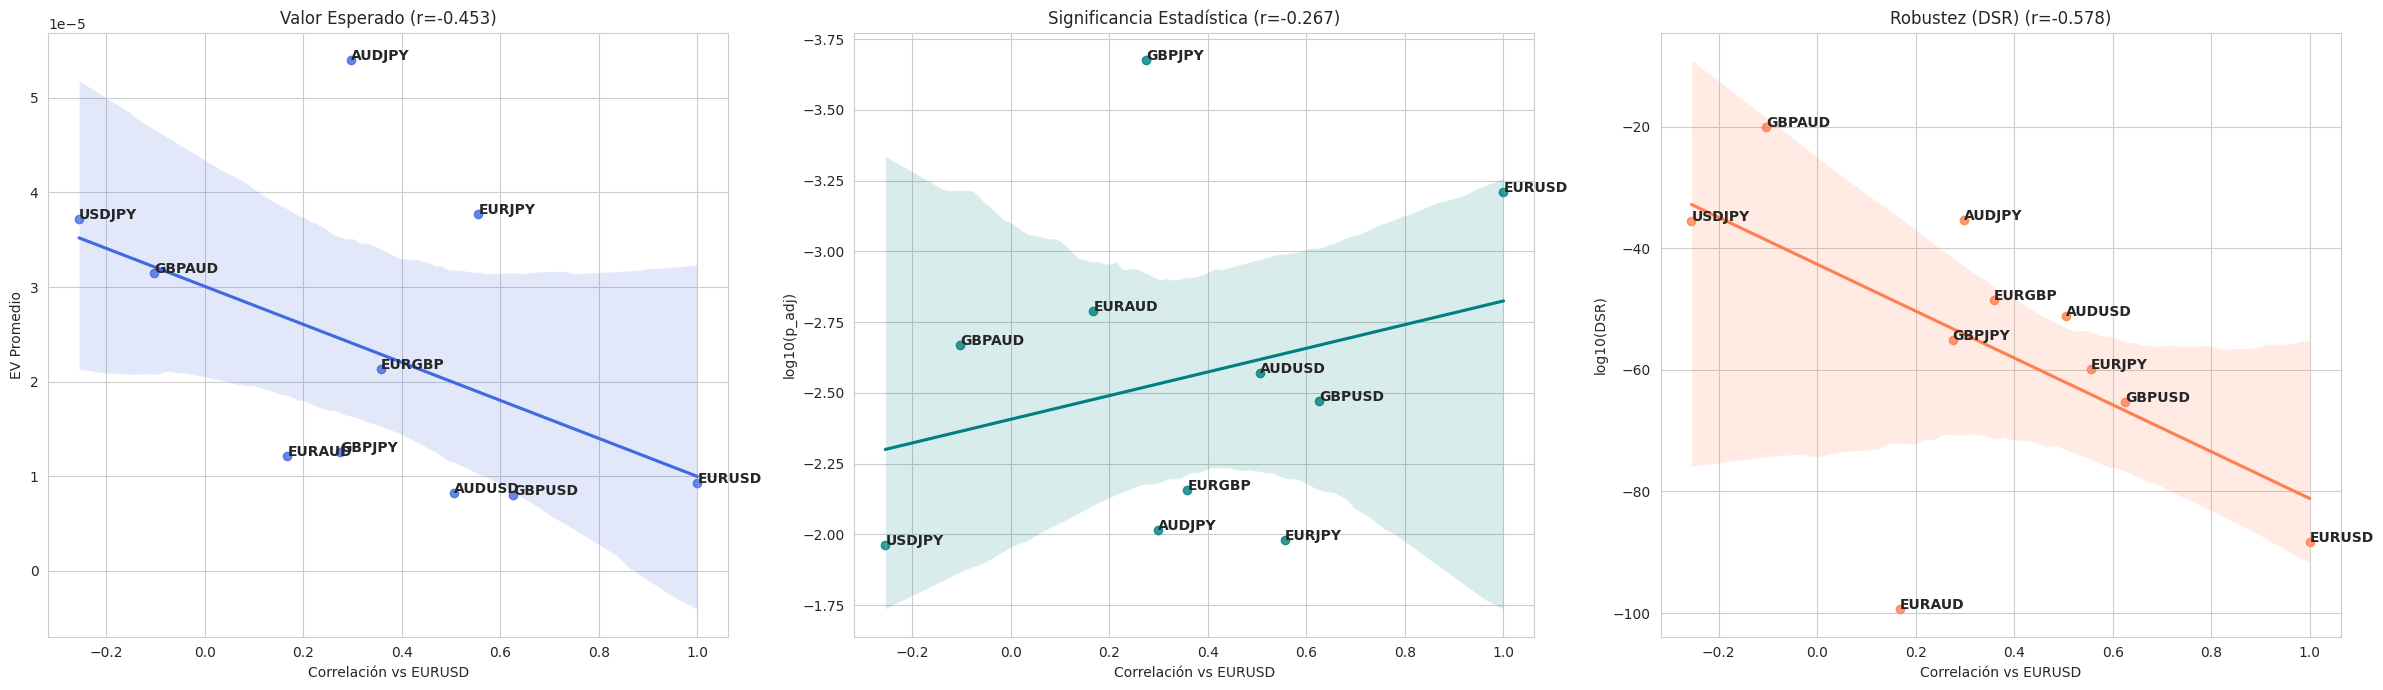

        count      corr       ev    p_adj       dsr
pair                                               
AUDJPY     50  2.98e-01 5.40e-05 9.68e-03  4.04e-36
EURJPY     50  5.55e-01 3.77e-05 1.05e-02  1.62e-60
USDJPY     50 -2.55e-01 3.72e-05 1.09e-02  2.87e-36
GBPAUD     50 -1.03e-01 3.15e-05 2.14e-03  9.04e-21
EURGBP     50  3.58e-01 2.13e-05 7.00e-03  3.30e-49
GBPJPY     50  2.75e-01 1.26e-05 2.11e-04  7.67e-56
EURAUD     50  1.68e-01 1.21e-05 1.62e-03 4.20e-100
EURUSD     50  1.00e+00 9.25e-06 6.16e-04  5.67e-89
AUDUSD     50  5.05e-01 8.20e-06 2.68e-03  7.62e-52
GBPUSD     50  6.26e-01 8.02e-06 3.37e-03  5.70e-66


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# Configuración
PATH_RAW_NEW = "/content/all_raw_new.csv"
PATH_RAW_OLD = "/content/all_raw_old.csv"
DATA_FOLDER = "/content"
TARGET_PAIR = "EURUSD"
TOP_N = 50
METRICS = ["ev", "p_adj", "dsr"]

def get_dynamic_data(path_new, path_old, folder_prices, target_pair, top_n=50):
    if not os.path.exists(path_new) or not os.path.exists(path_old):
        raise FileNotFoundError("Archivos RAW no encontrados.")
    df_new = pd.read_csv(path_new); df_old = pd.read_csv(path_old)
    df_new['source'] = 'new'; df_old['source'] = 'old'
    df_alphas = pd.concat([df_new, df_old], ignore_index=True)
    perf_rows = []
    pairs_found = df_alphas['pair'].unique()
    for p in pairs_found:
        top_p = df_alphas[df_alphas['pair'] == p].sort_values('ev', ascending=False).head(top_n)
        if not top_p.empty:
            perf_rows.append({'pair': p, 'ev': top_p['ev'].mean(), 'p_adj': top_p['p_adj'].mean(), 'dsr': top_p['dsr'].mean(), 'count': len(top_p)})
    df_perf = pd.DataFrame(perf_rows).set_index('pair')
    files = os.listdir(folder_prices); all_rets = {}
    for p in pairs_found:
        f = next((f for f in files if p in f and 'ASK' in f), None)
        if f:
            try:
                tmp = pd.read_csv(os.path.join(folder_prices, f), usecols=['Local time', 'Close'])
                try: tmp['Local time'] = pd.to_datetime(tmp['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', utc=True)
                except: tmp['Local time'] = pd.to_datetime(tmp['Local time'])
                tmp.set_index('Local time', inplace=True)
                all_rets[p] = np.log(tmp['Close'] / tmp['Close'].shift(1))
            except: continue
    df_rets = pd.DataFrame(all_rets).dropna()
    df_perf['corr'] = df_rets.corr()[target_pair]
    return df_perf.dropna(subset=['corr'])

# Procesamiento y visualización
try:
    df = get_dynamic_data(PATH_RAW_NEW, PATH_RAW_OLD, DATA_FOLDER, TARGET_PAIR, TOP_N)
    df['log_padj'] = np.log10(df['p_adj'].replace(0, 1e-300))
    df['log_dsr'] = np.log10(df['dsr'].clip(lower=1e-300))
    sns.set_style("whitegrid")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 7))
    def plot_regression(ax, x_col, y_col, title, y_label, invert_y=False, color='blue'):
        sns.regplot(x=x_col, y=y_col, data=df, ax=ax, color=color)
        for i in range(len(df)):
            ax.annotate(df.index[i], (df[x_col].iat[i], df[y_col].iat[i]), fontsize=10, fontweight='bold')
        if len(df) > 1:
            slope, intercept, r, p, _ = stats.linregress(df[x_col], df[y_col])
            ax.set_title(f"{title} (r={r:.3f})")
        ax.set_xlabel(f"Correlación vs {TARGET_PAIR}"); ax.set_ylabel(y_label)
        if invert_y: ax.invert_yaxis()
    plot_regression(ax1, 'corr', 'ev', 'Valor Esperado', 'EV Promedio', color='royalblue')
    plot_regression(ax2, 'corr', 'log_padj', 'Significancia Estadística', 'log10(p_adj)', invert_y=True, color='teal')
    plot_regression(ax3, 'corr', 'log_dsr', 'Robustez (DSR)', 'log10(DSR)', color='coral')
    plt.tight_layout(); plt.show()
    print(df[['count', 'corr', 'ev', 'p_adj', 'dsr']].sort_values('ev', ascending=False))
except Exception as e:
    print(f"Error: {e}")

Por esto me parece importante en el analisis de datos, machine learning y finanzas hacer la menor cantidad de suposiciones porque pensariamos (y es lo estandard) que a mayor correlacion mejor pero vemos que no es el caso, si fuaes de alguna forma seria al contrario.

Disclaimer: Son pocos pares como para una conclusion reforzada pero se vé la tendencia.

# **Conclusiones y posibles mejoras futuras**

Despues de todo el esfuerzo no hemos conseguido ningun alpha, ni hemos estado cerca ya que los DSR que salian eran extremadamente bajos (por la gran cantidad de combinacioes probablemente). Aun así este proyecto lo hice no tanto por encontrar un alpha, cosa que estaba casi seguro de que no pasaria, si no por tener el pipeline y el dia de mañana cuando tenga una idea o los conocimientos necesarios para crear uno o algunos tener el trabajo pesado hecho.

Mejoras futuras:

Usar ICEEMDAN en vez de EMD para DynETD.

Usar varios indicadores, ex: VR-MR para ver si hay tendencia o reversion y DPV para capturar la tendencia.

Determinar trend con lowess, EMD o reg polinomica en periodos grandes y pequeños para, si hay correlacion operar a favor del trend.